In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
% cd "drive/My Drive/covestro"

/content/drive/My Drive/covestro


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
df_50 = pd.read_csv('data_50_final.csv')
df_60 = pd.read_csv('data_60_final.csv')

In [5]:
df_50.head()

,Unnamed: 0,date,discharge,water_level,incoming,RS,NSH_TAG,day_diff,day_num
0,0,1/1/1965,1320.0,219.0,1358.89,1.2,0.0,1.0,1.0
1,1,1/2/1965,1650.0,272.0,1814.94,0.3,0.0,1.0,2.0
2,2,1/3/1965,1950.0,315.0,1939.09,0.1,0.0,1.0,3.0
3,3,1/4/1965,1870.0,304.0,1885.80,0.0,0.0,1.0,4.0
4,4,1/5/1965,1870.0,304.0,1877.25,1.2,0.0,1.0,5.0


In [6]:
pred_idx = df_50[df_50.day_diff == 17].index    # indices AFTER which we have to predict
pred_idx

Int64Index([  105,   211,   317,   423,   529,   635,   741,   847,   953,
             1059,
            ...
            16535, 16641, 16747, 16853, 16959, 17065, 17171, 17277, 17383,
            17489],
           dtype='int64', length=165)

In [0]:
def train_interval_data(df, data_idx, win):
  xdata, ydata = [], []

  for idx in range(data_idx-90+1+win,data_idx+1):
    
    y_out = df.water_level.iloc[idx]#.to_numpy()
    x_ip = df[['discharge', 'incoming', 'RS', 'NSH_TAG']].iloc[idx].to_numpy()
    # y_ip = y[idx-win:idx]
    y_ip = df.water_level.iloc[idx-win:idx].to_numpy()
    
    all_ip = np.append(x_ip, y_ip)
    xdata.append(all_ip)
    ydata.append(y_out)
    # print(y_out)

  return xdata, ydata

In [0]:
def train_data(df, win=5):
  xtrain, ytrain = [], []
  for index in pred_idx:
    xtr, ytr = train_interval_data(df, index, win)
    xtrain.append(xtr)
    ytrain.append(ytr)

  return np.array(xtrain), np.array(ytrain)

In [0]:
XT, YT = train_data(df_50, win=5)
# Returns Array shapes of X = [intervals, 90-win, win+4], Y = [intervals, 90-win]


In [0]:
x_train = XT.reshape(-1, XT.shape[-1])
y_train = YT.reshape(-1, 1)

In [12]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
from keras.initializers import glorot_uniform

In [0]:
def build_model(x_train, y_train):
  m = x_train.shape[-1]

  model = Sequential([
      # Dropout(0.2),
      # BatchNormalization(),
      
      # '''Best for 20 previous y's '''
      # Dense(96, input_shape=(m,), activation='relu', kernel_initializer=),
      # Dense(128, activation='relu'),
      # Dense(64, activation='relu'),
      # Dense(16, activation='relu'),
      

      Dense(64, input_shape=(m,), activation='relu',kernel_initializer=glorot_uniform()),
      # Dense(128, activation='relu'),
      Dense(64, activation='relu',kernel_initializer=glorot_uniform()),
      # Dense(32, activation='relu',kernel_initializer=glorot_uniform()),
      
      # Activation('relu'),
      Dense(1, activation='linear',kernel_initializer=glorot_uniform())
  ])

  model.compile(optimizer='adam', loss='mse', metrics=['mse'])
  # model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

  return model

In [15]:
import keras
from keras.layers import Input, Dense, LSTM, Embedding
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model = build_model(x_train, y_train)

In [21]:
# Fitting on model
print('Fitting')
n_epochs= 1000
batch_size = 32
# es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)  # , mode='min'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=0, save_best_only=True)  # , mode='min'
# fit model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=n_epochs, shuffle=False,
                    batch_size = batch_size, verbose=1, callbacks=[mc, reduce_lr]) # reduce_lr, 

Fitting
Train on 11220 samples, validate on 2805 samples
Epoch 1/1000
11220/11220 [==============================] - 1s 88us/step - loss: 94.9155 - mean_squared_error: 94.9155 - val_loss: 107.7601 - val_mean_squared_error: 107.7601
Epoch 2/1000
11220/11220 [==============================] - 1s 86us/step - loss: 94.9127 - mean_squared_error: 94.9127 - val_loss: 107.7584 - val_mean_squared_error: 107.7584
Epoch 3/1000
11220/11220 [==============================] - 1s 88us/step - loss: 94.9103 - mean_squared_error: 94.9103 - val_loss: 107.7541 - val_mean_squared_error: 107.7541
Epoch 4/1000
11220/11220 [==============================] - 1s 87us/step - loss: 94.9082 - mean_squared_error: 94.9082 - val_loss: 107.7529 - val_mean_squared_error: 107.7529
Epoch 5/1000
11220/11220 [==============================] - 1s 88us/step - loss: 94.9055 - mean_squared_error: 94.9055 - val_loss: 107.7484 - val_mean_squared_error: 107.7484
Epoch 6/1000
11220/11220 [==============================] - 1s 90us/

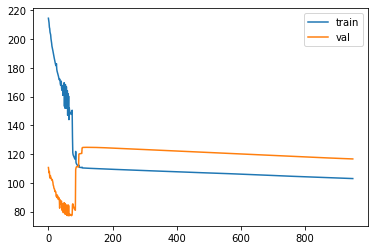

In [18]:
plt.plot(history.history['mean_squared_error'][50:], label='train')
plt.plot(history.history['val_mean_squared_error'][50:], label='val')
plt.legend()

In [0]:
history.history['mean_squared_error'][50:]

In [22]:
model.evaluate(x_train, y_train)#.shape

14025/14025 [==============================] - 0s 32us/step


[95.78348420168626, 95.78348420168626]

In [66]:
model.evaluate(x_train, y_train)

14025/14025 [==============================] - 1s 43us/step


[341.094503177636, 341.094503177636]

In [127]:
min(history.history['val_mean_squared_error'])

102.5160642826196

In [120]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error', 'lr'])

In [0]:
# y1 = df_50.water_level.iloc[i0+1]

def test_parser(df, model, win=5):
  test_pred = []
  diff_pred = []
  for index in pred_idx:
    y_ip = df.water_level.iloc[index-win+1:index+1].to_numpy() # For the 1st day
    y0 = df.water_level.iloc[index]  # Value with which to compare
    for days in range(3):
      x_ip = df[['discharge', 'incoming', 'RS', 'NSH_TAG']].iloc[index+days].to_numpy()
      all_ip = np.append(x_ip, y_ip).reshape(1,-1)
      y_out = model.predict( all_ip )
      test_pred.append(y_out.flatten())

      diff_pred.append(y_out.flatten()[0] - y0)
      y_ip = np.append(y_ip, y_out)[1:]     # updating with new y_out and removing the 1st element

  return diff_pred

predictions = test_parser(df_50 ,model, win=5)

In [0]:
predictions

In [0]:
with open('submit.csv', 'a+') as f:
  for p in predictions:
    f.write(str(p) + '\n')

In [0]:
def build_model(x_train, y_train):   # For 60
  m = x_train.shape[-1]

  model = Sequential([
      # Dropout(0.2),
      # BatchNormalization(),
      
      # '''Best for 20 previous y's '''
      # Dense(96, input_shape=(m,), activation='relu', kernel_initializer=),
      # Dense(128, activation='relu'),
      # Dense(64, activation='relu'),
      # Dense(16, activation='relu'),
      

      Dense(96, input_shape=(m,), activation='relu',kernel_initializer=glorot_uniform()),
      # Dense(128, activation='relu'),
      Dense(64, activation='relu',kernel_initializer=glorot_uniform()),
      # Dense(32, activation='relu',kernel_initializer=glorot_uniform()),
      
      # Activation('relu'),
      Dense(1, activation='linear',kernel_initializer=glorot_uniform())
  ])

  model.compile(optimizer='adam', loss='mse', metrics=['mse'])
  # model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

  return model

In [0]:
XT, YT = train_data(df_60, win=5)
x_train = XT.reshape(-1, XT.shape[-1])
y_train = YT.reshape(-1, 1)

In [0]:
model = build_model(x_train, y_train)

In [41]:
  # Fitting on model
print('Fitting')
n_epochs= 1000
batch_size = 32
# es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)  # , mode='min'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=0, save_best_only=True)  # , mode='min'
# fit model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=n_epochs, shuffle=False,
                    batch_size = batch_size, verbose=1, callbacks=[mc, reduce_lr]) # reduce_lr, 


Fitting
Train on 11220 samples, validate on 2805 samples
Epoch 1/1000
11220/11220 [==============================] - 1s 105us/step - loss: 121.1261 - mean_squared_error: 121.1261 - val_loss: 94.3073 - val_mean_squared_error: 94.3073
Epoch 2/1000
11220/11220 [==============================] - 1s 100us/step - loss: 121.1282 - mean_squared_error: 121.1282 - val_loss: 94.2904 - val_mean_squared_error: 94.2904
Epoch 3/1000
11220/11220 [==============================] - 1s 109us/step - loss: 121.1266 - mean_squared_error: 121.1266 - val_loss: 94.2726 - val_mean_squared_error: 94.2726
Epoch 4/1000
11220/11220 [==============================] - 1s 101us/step - loss: 121.1241 - mean_squared_error: 121.1241 - val_loss: 94.2956 - val_mean_squared_error: 94.2956
Epoch 5/1000
11220/11220 [==============================] - 1s 105us/step - loss: 121.1239 - mean_squared_error: 121.1239 - val_loss: 94.2928 - val_mean_squared_error: 94.2928
Epoch 6/1000
11220/11220 [==============================] - 1s 

In [0]:
# plt.plot(history.history['mean_squared_error'][50:], label='train')
plt.plot(history.history['val_mean_squared_error'][50:], label='val')
plt.legend()

In [0]:
predictions = test_parser(df_60 ,model, win=5)

with open('submit.csv', 'a+') as f:
  for p in predictions:
    f.write(str(p) + '\n')


In [0]:
def whole_module(df):
  pred_idx = df[df.day_diff == 17].index    # indices AFTER which we have to predict
  XT, YT = train_data(df, win=10)
  x_train = XT.reshape(-1, XT.shape[-1])
  y_train = YT.reshape(-1, 1)

  model = build_model(x_train, y_train)
  # Fitting on model
  print('Fitting')
  n_epochs= 1000
  batch_size = 32
  # es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)  # , mode='min'
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=0, save_best_only=True)  # , mode='min'
  # fit model
  history = model.fit(x_train, y_train, validation_split=0.2, epochs=n_epochs, shuffle=False,
                      batch_size = batch_size, verbose=1, callbacks=[mc, reduce_lr]) # reduce_lr, 

  # plt.plot(history.history['mean_squared_error'], label='train')
  plt.plot(history.history['val_mean_squared_error'], label='val')
  plt.legend()
  
  # model.fit(x_train, y_train, validation_split=0.2, shuffle=False, )

  predictions = test_parser(df_50 ,model, win=10)

  with open('submit.csv', 'w+') as f:
    for p in predictions:
      f.write(str(p) + '\n')


# Scikit Learn models